In [1]:
# Module Importations
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow.keras as keras

# Print versioning information
print('keras version =', keras.__version__)
print('numpy version =', np.__version__)
print('seaborn version =', sns.__version__)  
print('sklearn version =', sklearn.__version__)
print('tensorflow version =', tf.__version__)

keras version = 2.4.0
numpy version = 1.19.4
seaborn version = 0.10.0
sklearn version = 0.22.2.post1
tensorflow version = 2.4.1


In [2]:
# Custom Module Imports
from Source.data import load_data
from Source.data import split_data
from Source.models import model_evaluation
from Source.models import keras_helpers
from Source.models import tensorboard_helpers
from Source.visualisation import figures_helper

[keras_helpers]Tensorflow version: 2.4.1
[keras_helpers]keras version = 2.4.0


In [3]:
# Constants
SAVE_FIGURES = False
TRAIN_MODELS = False

In [4]:
# Load dataset
df_plant1 = load_data.load_pickled_data("df_plant1_feat_eng.pkl")
df_plant2 = load_data.load_pickled_data("df_plant2_feat_eng.pkl")

Loading pickled dataframe started ...
Loading pickled dataframe complete ...
Loading pickled dataframe started ...
Loading pickled dataframe complete ...


In [5]:
df_plant1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71808 entries, 0 to 71806
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DATE_TIME        71808 non-null  datetime64[ns]
 1   PLANT_ID         71808 non-null  object        
 2   SOURCE_KEY       71808 non-null  object        
 3   DC_POWER         71808 non-null  float64       
 4   DAILY_YIELD      71808 non-null  float64       
 5   AMB_TEMP         71808 non-null  float64       
 6   MOD_TEMP         71808 non-null  float64       
 7   IRRADIATION      71808 non-null  float64       
 8   DATE             71808 non-null  object        
 9   TIME_OF_DAY      71808 non-null  object        
 10  HOUR             71808 non-null  int64         
 11  DAY              71808 non-null  int64         
 12  WEEKDAY          71808 non-null  object        
 13  MONTH            71808 non-null  int64         
 14  YEAR             71808 non-null  int64

In [6]:
# Drop unrequired data columns

# Identify columns to drop
cols_to_keep = ['DC_POWER', 'AMB_TEMP', 'MOD_TEMP', 'IRRADIATION', 'TIME_FLOAT']
cols_to_drop = []

for col in df_plant1.columns:
    if col not in cols_to_keep:
        cols_to_drop.append(col)

for df in [df_plant1, df_plant2]:
    df.drop(cols_to_drop, axis = 1, inplace = True)

df_plant2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71808 entries, 0 to 71807
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DC_POWER     71808 non-null  float64
 1   AMB_TEMP     71808 non-null  float64
 2   MOD_TEMP     71808 non-null  float64
 3   IRRADIATION  71808 non-null  float64
dtypes: float64(4)
memory usage: 2.7 MB


In [7]:
# Split data into training / evaluation sets
training_set_plant1, evaluation_set_plant1 = split_data.split_train_eval(df_plant1, 0.2)
training_set_plant2, evaluation_set_plant2 = split_data.split_train_eval(df_plant2, 0.2)

Original Data Items: 71808
Training Data Items: 57447
Evaluation Data Items: 14361
Original Data Items: 71808
Training Data Items: 57447
Evaluation Data Items: 14361


In [8]:
# Create DC Power Target datasets

# Modify training sets
dc_power_training_data_pt1 = training_set_plant1.drop('DC_POWER', axis = 1)
dc_label_data_pt1 = training_set_plant1['DC_POWER'].copy()

dc_power_training_data_pt2 = training_set_plant2.drop('DC_POWER', axis = 1)
dc_label_data_pt2 = training_set_plant2['DC_POWER'].copy()

# Modify evaluation sets
dc_evaluation_data_pt1 = evaluation_set_plant1.drop('DC_POWER', axis = 1)
dc_eval_label_data_pt1 = evaluation_set_plant1['DC_POWER'].copy()

dc_evaluation_data_pt2 = evaluation_set_plant2.drop('DC_POWER', axis = 1)
dc_eval_label_data_pt2 = evaluation_set_plant2['DC_POWER'].copy()

In [9]:
# Check shape of arrays
print('Plant 1:')
print('Fit Train:', dc_power_training_data_pt1.shape)
print('Fit Label:', dc_label_data_pt1.shape)
print('Eval Train:', dc_evaluation_data_pt1.shape)
print('Eval Label:', dc_eval_label_data_pt1.shape)

print('Plant 2:')
print('Fit Train:', dc_power_training_data_pt2.shape)
print('Fit Label:', dc_label_data_pt2.shape)
print('Eval Train:', dc_evaluation_data_pt2.shape)
print('Eval Label:', dc_eval_label_data_pt2.shape)

Plant 1:
Fit Train: (57447, 3)
Fit Label: (57447,)
Eval Train: (14361, 3)
Eval Label: (14361,)
Plant 2:
Fit Train: (57447, 3)
Fit Label: (57447,)
Eval Train: (14361, 3)
Eval Label: (14361,)


In [10]:
# Normalise Inputs
normalise_inputs = True
normalise_outputs = False

normaliser = MinMaxScaler()

if normalise_inputs == True:

    # Transform training sets
    dc_power_training_data_pt1 = normaliser.fit_transform(dc_power_training_data_pt1)
    dc_power_training_data_pt2 = normaliser.fit_transform(dc_power_training_data_pt2)

    # Transform evaluation sets
    dc_evaluation_data_pt1 = normaliser.fit_transform(dc_evaluation_data_pt1)
    dc_evaluation_data_pt2 = normaliser.fit_transform(dc_evaluation_data_pt2)

if normalise_outputs == True:

    # Transform training sets
    dc_label_data_pt1 = normaliser.fit_transform(dc_label_data_pt1)
    dc_label_data_pt2 = normaliser.fit_transform(dc_label_data_pt2)

    # Transform evaluation sets
    dc_eval_label_data_pt1 = normaliser.fit_transform(dc_eval_label_data_pt1)
    dc_eval_label_data_pt2 = normaliser.fit_transform(dc_eval_label_data_pt2)

In [11]:
# Check values after normalisation
dc_power_training_data_pt1

array([[0.69418927, 0.39836143, 0.24685468],
       [0.10297219, 0.06348367, 0.02010156],
       [0.10195445, 0.0510256 , 0.        ],
       ...,
       [0.3994604 , 0.20367104, 0.07955333],
       [0.31878711, 0.09578908, 0.        ],
       [0.45269604, 0.48094315, 0.44556097]])

In [12]:
# Create train and test arrays (plant 1)
X_train_pt1, X_test_pt1, y_train_pt1, y_test_pt1 = train_test_split(dc_power_training_data_pt1, dc_label_data_pt1, test_size = 0.2, random_state = 0)

print(X_train_pt1)
print(y_train_pt1)

[[0.77310878 0.77031963 0.62255649]
 [0.31338184 0.08745068 0.        ]
 [0.26876718 0.23906034 0.09710624]
 ...
 [0.11465821 0.06056427 0.        ]
 [0.15250767 0.05541926 0.        ]
 [0.25835535 0.07128375 0.        ]]
16030    936.842857
4052       0.000000
71148    178.350000
71233    154.514286
24592    414.100000
            ...    
14020    560.000000
50198     31.471429
65767      0.000000
50797      0.000000
12524      0.000000
Name: DC_POWER, Length: 45957, dtype: float64


In [13]:
# Initial MLP (Target - DC Power, Plant 1)

if TRAIN_MODELS == True:
    # Clear existing models
    keras.backend.clear_session()

    # Build model
    model = keras_helpers.build_multilayer_perceptron()

    # Name model
    model_type = "MLP_DC_Plant1"
    model_id = keras_helpers.name_model(model_type)
    filepath_full = keras_helpers.make_save_string(model_id)

    # Set save and earlystop callbacks
    earlystop_cb = keras.callbacks.EarlyStopping(patience = 5)
    checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = filepath_full, save_best_only = True)

    # Train model
    model.fit(X_train_pt1, y_train_pt1, epochs = 20, validation_data = (X_test_pt1, y_test_pt1), callbacks =[checkpoint_cb, earlystop_cb])

In [14]:
# Evaluate MLP Model (DC Power, Plant 1)

if TRAIN_MODELS == False:
    filepath_full = r'C:\Developer\solar-power-generation-project\Models\WJ_MLP_DC_Plant1_2021_06_17-10_06_45.h5'
    
print("Model Path:", filepath_full)

# Load model
model = keras.models.load_model(filepath_full)

# Summarise model
model.summary()

# Make predictions
dc_pred_eval = model.predict(dc_evaluation_data_pt1)

# Determine model prediction stats
model_name = "MLP_DC_Plant1"
model_evaluation.evaluate_model(model_name, dc_eval_label_data_pt1, dc_pred_eval)
rmse, mae, r2 = model_evaluation.return_model_evaluation_stats(dc_eval_label_data_pt1, dc_pred_eval)

Model Path: C:\Developer\solar-power-generation-project\Models\WJ_MLP_DC_Plant1_2021_06_17-10_06_45.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
MLP_DC_Plant1 rmse (Eval): 57.95040260050794
MLP_DC_Plant1 mae (Eval): 25.128179285486347
MLP_DC_Plant1 r2 (Eval): 0.9789304469388972


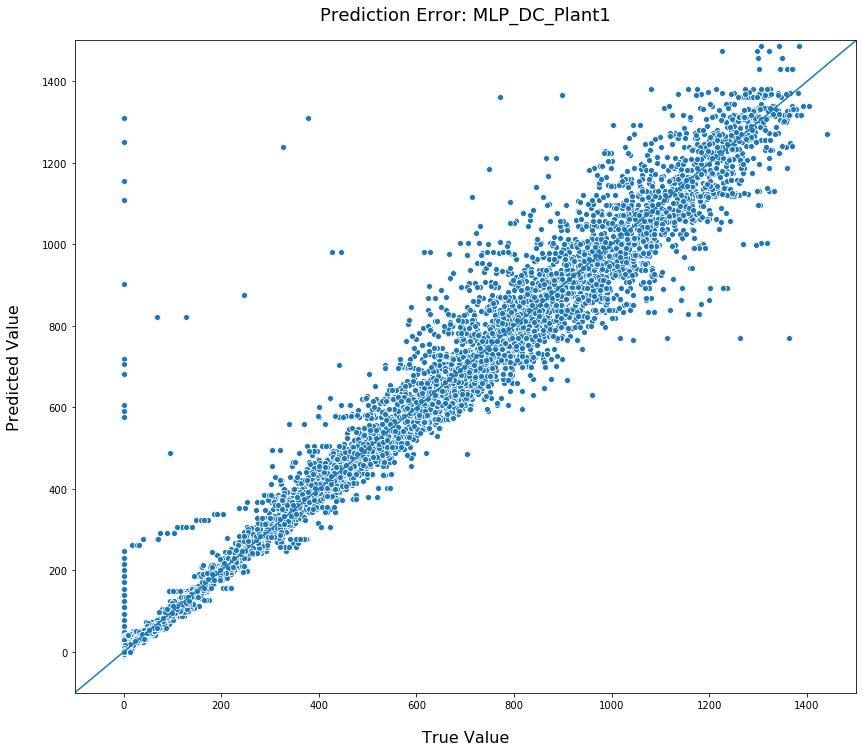

In [15]:
# Visualise Prediction Error - MLP (Target - DC Power, Plant 1)
fig, ax = plt.subplots(figsize = (14,12))

# Generate scatter plot comparing predicted and actual
sns.scatterplot(x = dc_eval_label_data_pt1, y = dc_pred_eval.flatten(), ax = ax)

# Establish symmetry and equality line
lims = [-100, 1500]
plt.xlim(lims)
plt.ylim(lims)
equality = plt.plot(lims, lims)

# Set title, axes
plt.title(f"Prediction Error: {model_name}", fontsize = figures_helper.TITLE_FONTSIZE, pad = 20)
plt.xlabel("True Value", fontsize = 16, labelpad = 20)
plt.ylabel("Predicted Value", fontsize = 16, labelpad = 20)

if SAVE_FIGURES == True: 
    name = 'MLP_Pt1_Prediction_Error'
    save_string = figures_helper.generate_fig_save_string(name)
    fig.savefig(save_string, format = 'png', dpi = 600, bbox_inches = 'tight')

In [16]:
# Visualise Residuals - Lin Reg (Target - DC Power, Plant 1)
fig, ax = plt.subplots(figsize = (14,12))

# Initialise visualiser
visualiser_residual = ResidualsPlot(model, ax = ax)

# Fit visualiser
visualiser_residual.fit(dc_power_training_data_pt1, dc_label_data_pt1)
visualiser_residual.score(dc_evaluation_data_pt1, dc_eval_label_data_pt1)
visualiser_residual.poof()

if SAVE_FIGURES == True: 
    name = 'MLP_DC_Residuals_Plot'
    save_string = figures_helper.generate_fig_save_string(name)
    fig.savefig(save_string, format = 'png', dpi = 600, bbox_inches = 'tight')

NameError: name 'ResidualsPlot' is not defined

In [15]:
# Setup tensorboard for logging 
x = tensorboard_helpers.get_run_logdir()

# Print tensorboard directory
print(x)

c:\Developer\solar-power-generation-project\Models\TensorBoard\run_2021_07_09-09_51_02


In [16]:
# Optimised MLP (Target - DC Power, Plant 1)

if TRAIN_MODELS == True:
    
    # Clear existing models
    keras.backend.clear_session()

    # Establish parameter distribution for tuning
    param_distribs = {
        "n_hidden": (4, 8, 12, 16, 20),
        "n_neurons": (5, 10, 20, 40, 60, 80, 100),
        "learning_rate": (1e-1, 1e-2, 1e-3, 1e-4),
    }

    # Build model
    wrapped_model = keras_helpers.wrap_model()

    # Initialise random search
    rnd_search_cv = RandomizedSearchCV(wrapped_model, param_distribs, n_iter = 10, cv = 3)

    # Name model
    model_type = "MLP_Opt_DC_Plant1"
    model_id = keras_helpers.name_model(model_type)
    filepath_full = keras_helpers.make_save_string(model_id)

    # Set save and earlystop callbacks
    earlystop_cb = keras.callbacks.EarlyStopping(patience = 3)
    checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = filepath_full, save_best_only = True)

    # Set TensorBoard callback for logging
    tb_logdir = tensorboard_helpers.get_run_logdir()
    tensorboard_cb = keras.callbacks.TensorBoard(tb_logdir)

    # Train model
    rnd_search_cv.fit(X_train_pt1, y_train_pt1, epochs = 100, validation_data = (X_test_pt1, y_test_pt1), callbacks = [checkpoint_cb, earlystop_cb, tensorboard_cb], verbose = 0)

In [17]:
# Evaluate MLP Model (DC Power, Plant 1)

if TRAIN_MODELS == False:
    filepath_full = r'C:\Developer\solar-power-generation-project\Models\WJ_MLP_Opt_DC_Plant1_2021_06_17-10_07_18.h5'

print("Model Path:", filepath_full)

wrapped_model = keras.models.load_model(filepath_full)

# Summarise model
wrapped_model.summary()

# Make predictions
dc_pred_eval = wrapped_model.predict(dc_evaluation_data_pt1)

model_name = "MLP_Opt_DC_pt1"
model_evaluation.evaluate_model(model_name, dc_eval_label_data_pt1, dc_pred_eval)
rmse, mae, r2 = model_evaluation.return_model_evaluation_stats(dc_eval_label_data_pt1, dc_pred_eval)

Model Path: C:\Developer\solar-power-generation-project\Models\WJ_MLP_Opt_DC_Plant1_2021_06_17-10_07_18.h5
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 5)                 20        
_________________________________________________________________
dense_82 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_83 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_84 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_85 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_86 (Dense)             (None, 5)                 30        
_____________

In [18]:
# Create train and test arrays (plant 2)
X_train_pt2, X_test_pt2, y_train_pt2, y_test_pt2 = train_test_split(dc_power_training_data_pt2, dc_label_data_pt2, test_size = 0.2, random_state = 0)

print(X_train_pt2)
print(y_train_pt2)

[[0.78718932 0.86385524 0.75714748]
 [0.40111725 0.13940226 0.        ]
 [0.366359   0.24734289 0.16542722]
 ...
 [0.17626336 0.06610678 0.        ]
 [0.19348786 0.04786465 0.        ]
 [0.30564703 0.10208519 0.        ]]
16031    1196.980000
4052        0.000000
71148     285.164286
71234     140.678571
24593     896.435714
            ...     
14020     872.093333
50199      57.906667
65768       0.000000
50783       0.000000
12524       0.000000
Name: DC_POWER, Length: 45957, dtype: float64


In [19]:
# Initial MLP (Target - DC Power, Plant 2)

if TRAIN_MODELS == True:
    
    # Clear existing models
    keras.backend.clear_session()

    # Build model
    model = keras_helpers.build_multilayer_perceptron()

    # Name model
    model_type = "MLP_DC_Plant2"
    model_id = keras_helpers.name_model(model_type)
    filepath_full = keras_helpers.make_save_string(model_id)

    # Set save and earlystop callbacks
    earlystop_cb = keras.callbacks.EarlyStopping(patience = 5)
    checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = filepath_full, save_best_only = True)

    # Train model
    model.fit(X_train_pt2, y_train_pt2, epochs = 20, validation_data = (X_test_pt2, y_test_pt2), callbacks =[checkpoint_cb, earlystop_cb])

In [20]:
# Evaluate MLP Model (DC Power, Plant 2)

if TRAIN_MODELS == False:
    filepath_full = r'C:\Developer\solar-power-generation-project\Models\WJ_MLP_DC_Plant2_2021_06_17-10_25_09.h5'

print("Model Path:", filepath_full)

# Load model
model = keras.models.load_model(filepath_full)

# Summarise model
model.summary()

# Make predictions
dc_pred_eval = model.predict(dc_evaluation_data_pt2)

# Determine model prediction stats
model_name = "MLP_DC"
model_evaluation.evaluate_model(model_name, dc_eval_label_data_pt2, dc_pred_eval)
rmse, mae, r2 = model_evaluation.return_model_evaluation_stats(dc_eval_label_data_pt2, dc_pred_eval)

Model Path: C:\Developer\solar-power-generation-project\Models\WJ_MLP_DC_Plant2_2021_06_17-10_25_09.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
MLP_DC rmse (Eval): 233.78362970666456
MLP_DC mae (Eval): 132.08992482894666
MLP_DC r2 (Eval): 0.6041764450340577


In [21]:
# Setup tensorboard for logging 
x = tensorboard_helpers.get_run_logdir()

# Print tensorboard directory
print(x)

c:\Developer\solar-power-generation-project\Models\TensorBoard\run_2021_07_09-09_51_04


In [22]:
# Optimised MLP (Target - DC Power, Plant 2)

if TRAIN_MODELS == True:
    
    # Clear existing models
    keras.backend.clear_session()

    # Establish parameter distribution for tuning
    param_distribs = {
        "n_hidden": (4, 8, 12, 16),
        "n_neurons": (5, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200),
        "learning_rate": (1e-1, 1e-2, 1e-3, 1e-4),
    }

    # Build model
    wrapped_model = keras_helpers.wrap_model()

    # Initialise random search
    rnd_search_cv = RandomizedSearchCV(wrapped_model, param_distribs, n_iter = 10, cv = 3)

    # Name model
    model_type = "MLP_Opt_DC_Plant2"
    model_id = keras_helpers.name_model(model_type)
    filepath_full = keras_helpers.make_save_string(model_id)

    # Set save and earlystop callbacks
    earlystop_cb = keras.callbacks.EarlyStopping(patience = 3)
    checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = filepath_full, save_best_only = True)

    # Set TensorBoard callback for logging
    tb_logdir = tensorboard_helpers.get_run_logdir()
    tensorboard_cb = keras.callbacks.TensorBoard(tb_logdir)

    # Train model
    rnd_search_cv.fit(X_train_pt2, y_train_pt2, epochs = 100, validation_data = (X_test_pt2, y_test_pt2), callbacks = [checkpoint_cb, earlystop_cb, tensorboard_cb], verbose = 0)

In [23]:
# Evaluate MLP Model (DC Power, Plant 2)

if TRAIN_MODELS == False:
    filepath_full = r'C:\Developer\solar-power-generation-project\Models\WJ_MLP_Opt_DC_Plant2_2021_06_17-10_25_41.h5'

print("Model Path:", filepath_full)

wrapped_model = keras.models.load_model(filepath_full)

# Summarise model
wrapped_model.summary()

# Make predictions
dc_pred_eval = wrapped_model.predict(dc_evaluation_data_pt2)

model_name = "MLP_Opt_DC_pt2"
model_evaluation.evaluate_model(model_name, dc_eval_label_data_pt2, dc_pred_eval)
rmse, mae, r2 = model_evaluation.return_model_evaluation_stats(dc_eval_label_data_pt2, dc_pred_eval)

Model Path: C:\Developer\solar-power-generation-project\Models\WJ_MLP_Opt_DC_Plant2_2021_06_17-10_25_41.h5
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_313 (Dense)            (None, 120)               480       
_________________________________________________________________
dense_314 (Dense)            (None, 120)               14520     
_________________________________________________________________
dense_315 (Dense)            (None, 120)               14520     
_________________________________________________________________
dense_316 (Dense)            (None, 120)               14520     
_________________________________________________________________
dense_317 (Dense)            (None, 120)               14520     
_________________________________________________________________
dense_318 (Dense)            (None, 120)               14520     
____________